# Setup dependencies for Kaggle

Objective is to create a computer vision system capable of determining when these events ['start' 'challenge' 'end' 'throwin' 'play'] occur

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c dfl-bundesliga-data-shootout

100% 34.9G/34.9G [04:10<00:00, 126MB/s]
100% 34.9G/34.9G [04:10<00:00, 150MB/s]


In [6]:
! unzip dfl-bundesliga-data-shootout.zip

Archive:  dfl-bundesliga-data-shootout.zip
  inflating: clips/08fd33_0.mp4      
  inflating: clips/08fd33_1.mp4      
  inflating: clips/08fd33_2.mp4      
  inflating: clips/08fd33_3.mp4      
  inflating: clips/08fd33_4.mp4      
  inflating: clips/08fd33_5.mp4      
  inflating: clips/08fd33_6.mp4      
  inflating: clips/08fd33_7.mp4      
  inflating: clips/08fd33_8.mp4      
  inflating: clips/08fd33_9.mp4      
  inflating: clips/0a2d9b_0.mp4      
  inflating: clips/0a2d9b_1.mp4      
  inflating: clips/0a2d9b_2.mp4      
  inflating: clips/0a2d9b_3.mp4      
  inflating: clips/0a2d9b_4.mp4      
  inflating: clips/0a2d9b_5.mp4      
  inflating: clips/0a2d9b_6.mp4      
  inflating: clips/0a2d9b_7.mp4      
  inflating: clips/0a2d9b_8.mp4      
  inflating: clips/0a2d9b_9.mp4      
  inflating: clips/0bfacc_0.mp4      
  inflating: clips/0bfacc_1.mp4      
  inflating: clips/0bfacc_2.mp4      
  inflating: clips/0bfacc_3.mp4      
  inflating: clips/0bfacc_4.mp4      
  infla

# Load in data and do EDA

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
train = pd.read_csv("train.csv")
train.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [9]:
# Number of events per video
train["video_id"].value_counts()

1606b0e6_1    1249
35bd9041_0    1075
3c993bd2_0    1042
1606b0e6_0    1000
ecf251d4_0     980
3c993bd2_1     966
35bd9041_1     933
407c5a9e_1     858
cfbe2e94_0     823
4ffd5986_0     792
cfbe2e94_1     763
9a97dae4_1     737
Name: video_id, dtype: int64

In [10]:
print(train.columns)
print(train.event.unique())
print(train.event.value_counts())

Index(['video_id', 'time', 'event', 'event_attributes'], dtype='object')
['start' 'challenge' 'end' 'throwin' 'play']
play         3586
start        3418
end          3418
challenge     624
throwin       172
Name: event, dtype: int64


In [11]:
#for each 1/2 game how many of these event occured
train.query('["start","end"]not in event')\
.groupby('video_id')["event"].value_counts().unstack()\
.sort_values("play")

event,challenge,play,throwin
video_id,,,
cfbe2e94_1,38,232,15
4ffd5986_0,57,235,10
9a97dae4_1,48,237,6
cfbe2e94_0,35,241,29
407c5a9e_1,56,283,11
3c993bd2_1,70,289,17
35bd9041_1,57,290,12
1606b0e6_0,56,319,21
ecf251d4_0,46,324,16


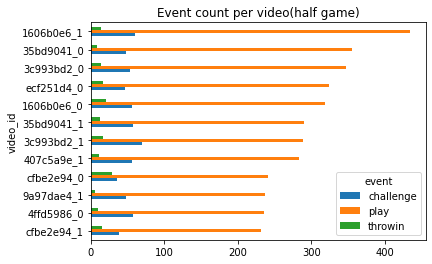

In [12]:
train.query('["start","end"]not in event')\
    .groupby('video_id')["event"].value_counts().unstack()\
    .sort_values("play")\
    .plot(kind="barh", title="Event count per video(half game)")
plt.show()

In [13]:
train.query('video_id == "1606b0e6_0"')\
    .sort_values("time")

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']
...,...,...,...,...
995,1606b0e6_0,3000.870000,play,"['pass', 'freekick']"
996,1606b0e6_0,3002.103519,end,NaN
997,1606b0e6_0,3012.231795,start,NaN
998,1606b0e6_0,3013.230000,play,"['pass', 'openplay']"


# Using Cv2

In [14]:
import cv2

In [15]:
cap=cv2.VideoCapture("./train/1606b0e6_0.mp4")
ret, img = cap.read()
print(ret)
cap.release()

True


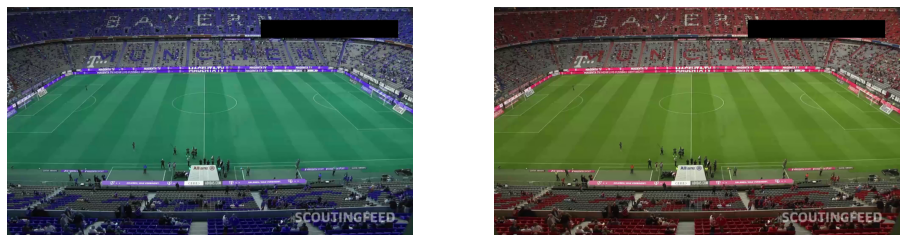

In [16]:
fig,(ax1, ax2)=plt.subplots(1, 2,figsize=(16,16))
ax1.imshow(img) # color is inverted BGR
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.axis("off")
ax2.axis("off")
plt.show()

In [29]:
#Frame rate (expressed in frames per second or FPS) is the frequency (rate) at 
#which consecutive images (frames) are captured or displayed
fps=25 
train["frame"]=train["time"]*fps
train["frame_rounded"]=train["frame"].round().astype(int)
train["event_id"]=train.index//3
train.tail()

,video_id,time,event,event_attributes,frame,frame_rounded,event_id
11213,ecf251d4_0,3056.587000,challenge,['opponent_dispossessed'],76414.675000,76415,3737
11214,ecf251d4_0,3058.072895,end,NaN,76451.822375,76452,3738
11215,ecf251d4_0,3068.280519,start,NaN,76707.012977,76707,3738
11216,ecf251d4_0,3069.547000,throwin,['pass'],76738.675000,76739,3738
11217,ecf251d4_0,3070.780519,end,NaN,76769.512977,76770,3739


In [27]:
cap = cv2.VideoCapture("./train/1606b0e6_0.mp4")

# Total number of frames in video
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Video height and width
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

# Get frames per second
fps = cap.get(cv2.CAP_PROP_FPS)

print(f'Frames {n_frames} Height {height}, Width {width} FPS : {fps:0.2f}')

Frames 85915 Height 1080.0, Width 1920.0 FPS : 25.00


In [18]:
# query() method also accepts the @ flag to mark local variables

cap=cv2.VideoCapture("./train/1606b0e6_0.mp4")
ret, img = cap.read()

for frame in range(85915):
  if ret == False:
    break

  ret, img=cap.read()

  cap.release()

In [1]:
cap.release()

NameError: name 'cap' is not defined